# 160. mnist dataset 손글씨 인식 - Multi-class Classification

- Basic Fully Connected Layer 이용

- nn.CrossEntropyLoss 이용

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset handling
- ``transforms.ToTensor()`` - image 를 tensor로 변환 
- ```SubsetSampler``` - 주어진 인덱스 목록에서 무작위로 비복원 추출

In [22]:
# download mnist data
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())

test_data = datasets.MNIST(root='./data', train=False, 
                           download=True, transform=transforms.ToTensor())

In [23]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)
print(train_data[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

torch.Size([1, 28, 28])
5


In [27]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

- Data 시각화

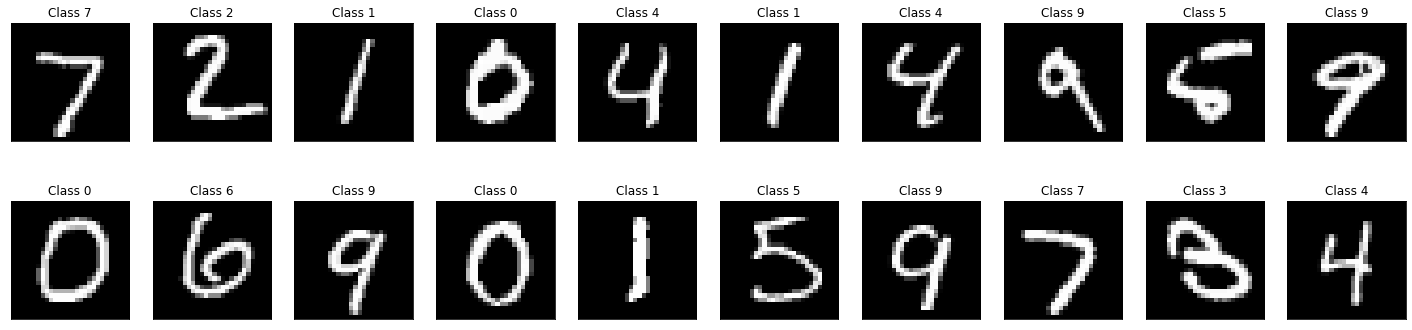

In [5]:
plt.figure(figsize=(25, 6))

for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.view(28, 28), cmap='gray')  
    plt.title("Class {}".format(y))
    plt.xticks([])
    plt.yticks([])

plt.show()

## Dataset Loader 생성

- Train dataset 을 Train 과 Validation set 으로 분리

In [6]:
valid_size = 0.2  # validation set 으로 사용할 train_dataset size

num_train = len(train_data)
indices = list(range(num_train))

np.random.shuffle(indices)   # shuffle data
split = int(np.floor(valid_size * num_train))  #split data size
train_idx, valid_idx = indices[split:], indices[:split]

# sampler 정의
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

- train, validation, test dataset 으로 3 분할

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                batch_size=batch_size, sampler=valid_sampler)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, 
                                batch_size=batch_size, shuffle=False)

### Model custom build

- nn.Linear 이용
- activation 으로 relu 함수 적용
- 2개의 hidden layer와 dropout 사용

<img src="linear.png" width="600" />

In [8]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(0.2)
        self.relu  = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

In [9]:
input_dim = 28 * 28
hidden_dim = 128
output_dim = 10

model = Net(input_dim, hidden_dim, output_dim)

### Model Summary

In [10]:
model

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [11]:
for k, v in model.state_dict().items():
    print(k, v.numel())
    
print("total trainable params", sum(p.numel() for p in model.parameters()))

fc1.weight 100352
fc1.bias 128
fc2.weight 16384
fc2.bias 128
fc3.weight 1280
fc3.bias 10
total trainable params 118282


In [12]:
for images, labels in train_loader:
    probs = model(images[0].view(-1, 28*28))
    break

print('outputs.shape : ', probs.shape)
# Look at sample probabilities
print("Sample probabilities:\n", probs[0].data)
# torch.argmax 로 가장 확률이 높은 output 선택
pred = torch.argmax(probs, dim=1)
pred

outputs.shape :  torch.Size([1, 10])
Sample probabilities:
 tensor([ 0.0454,  0.0599, -0.1012, -0.0430, -0.0340,  0.0795,  0.0409,  0.0051,
        -0.0045,  0.0936])


tensor([9])

### softmax 함수를 사용하여 output row 를 확률 분포로 바꾼다. 공식은 다음과 같다.


<img src="softmax.png" width="400" />

- output row 의 각 element $y_i$ 를 $e^{y_i}$ 로 변경하여 모든 element 를 양수로 만든다.  
- 각 element 를 모든 element 의 합으로 나누어 합계가 1 이 되도록 한다.  
- predicted label 은 torch.max 를 이용하여 각 row 에서 highest probability 값을 고른다.  

### Loss Function 정의

<img src="crossentropy.png" width="400" />

- 손실함수는 categorical cross-entropy 지정

In [13]:
criterion = nn.CrossEntropyLoss()

model.to(device)

- optimizer 는 Stochastic Gradient Descent 사용

In [14]:
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 50

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    train_acc  = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x.view(-1, 28 * 28))
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)  # (max values, indices)
        train_acc += (y_pred == y).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader)
    train_acc  = train_acc / len(train_loader)
    LOSS.append(train_loss)
    ACC.append(train_acc)
        
    model.eval()  #evaluaion mode
    
    val_loss = 0
    val_acc = 0
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)

        z = model(x.view(-1, 28 * 28))
        loss = criterion(z, y)
        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item()
    
    val_loss = val_loss / len(valid_loader)
    val_acc  = val_acc / len(valid_loader)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  
          valididation loss: {val_loss:.5f}',  
                    f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 1.35201,  valididation loss: 0.53479 train acc: 19.555333333333333, validation acc: 27.496
epoch 1 ==> train loss: 0.51264,  valididation loss: 0.37882 train acc: 27.11466666666667, validation acc: 28.632
epoch 2 ==> train loss: 0.40500,  valididation loss: 0.32151 train acc: 28.168666666666667, validation acc: 29.109333333333332
epoch 3 ==> train loss: 0.34777,  valididation loss: 0.28514 train acc: 28.752666666666666, validation acc: 29.384
epoch 4 ==> train loss: 0.30573,  valididation loss: 0.25413 train acc: 29.174, validation acc: 29.645333333333333
epoch 5 ==> train loss: 0.27473,  valididation loss: 0.22998 train acc: 29.406666666666666, validation acc: 29.909333333333333
epoch 6 ==> train loss: 0.24618,  valididation loss: 0.20925 train acc: 29.722666666666665, validation acc: 30.106666666666666
epoch 7 ==> train loss: 0.22761,  valididation loss: 0.19533 train acc: 29.875333333333334, validation acc: 30.194666666666667
epoch 8 ==> train loss: 0.21228, 

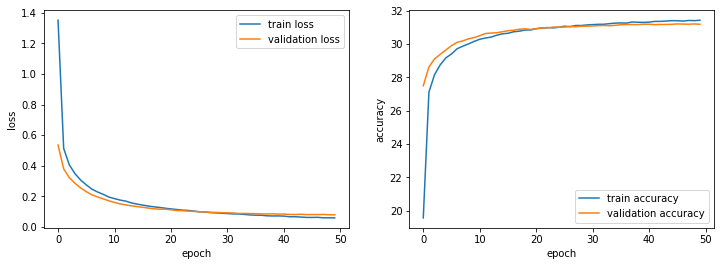

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

## Model 평가 - Test set 사용 

In [17]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x.view(-1, 28 * 28))
    _, y_pred = torch.max(z, 1)
    
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 97.87%


## Category 별 분류 성능 측정

accuracy of 0 = 99.08%
accuracy of 1 = 99.12%
accuracy of 2 = 97.97%
accuracy of 3 = 98.61%
accuracy of 4 = 98.17%
accuracy of 5 = 97.09%
accuracy of 6 = 97.81%
accuracy of 7 = 97.28%
accuracy of 8 = 97.02%
accuracy of 9 = 96.33%


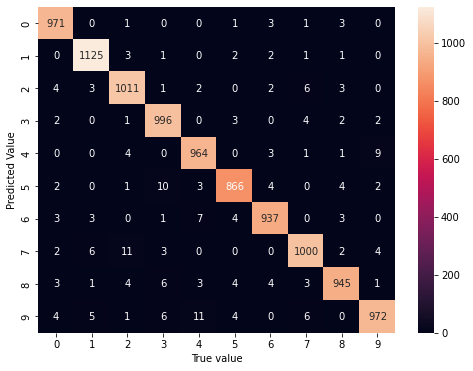

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

for i in range(10):
    print(f"accuracy of {i} = {cm[i][i] / cm[i].sum() * 100:.2f}%")

## Sample Test 결과 시각화

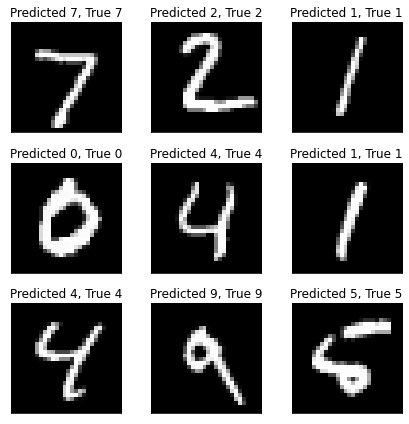

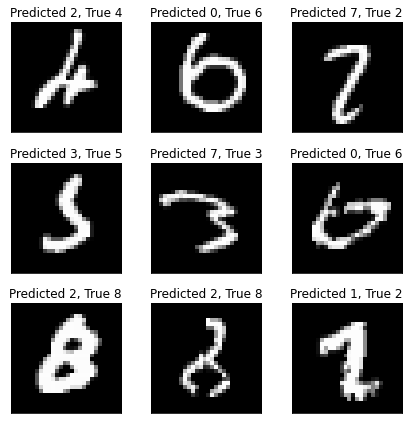

In [19]:
%matplotlib inline

plt.figure(figsize=(6, 6))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

plt.figure(figsize=(6, 6))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_data[idx][0].view(28, 28), cmap='gray')
    plt.title("Predicted {}, True {}".format(predictions[idx], labels[idx]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()